In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 
from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import diffprivlib as dp

import nbfuns
import importlib
importlib.reload(nbfuns)

import experiments.data_utils

import statsmodels.api as sm
import sys
import warnings

%matplotlib inline
#%matplotlib notebook

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
CLF_RANDOM_STATE=1234
DP_CLF_RANDOM_STATE=13371337
SHADOW_RANDOM_STATE=22222222
SPLIT_RANDOM_STATE=303030
RF_RANDOM_STATE=51516321

In [ ]:
(X_train, y_train), (X_test, y_test), (X_shadow, y_shadow) = experiments.data_utils.load_purchase100(shadow_size=0.75)

./datasets/dataset_purchase


In [ ]:
labels_train = np.argmax(y_train, axis=1)
labels_test = np.argmax(y_test, axis=1)

from sklearn import tree

dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train, labels_train)
print(dec_tree.score(X_test, labels_test))

tree_probs_train = dec_tree.predict_proba(X_train)
tree_probs_test = dec_tree.predict_proba(X_test)

0.10909754317684262


In [ ]:
clf = LogisticRegression(solver="lbfgs", random_state=CLF_RANDOM_STATE, multi_class="auto")
clf.fit(X_train, labels_train)

LogisticRegression(random_state=1234)

In [ ]:
baseline = clf.score(X_test, labels_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 67.25%


In [ ]:
train_acc = clf.score(X_train, labels_train)
print("Non-private train accuracy: %.2f%%" % (train_acc * 100))

Non-private train accuracy: 100.00%


In [ ]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

probs_train = clf.predict_proba(X_train)
probs_test = clf.predict_proba(X_test)

attack_types = [AttackType.THRESHOLD_ATTACK,
                AttackType.RANDOM_FOREST,
                AttackType.K_NEAREST_NEIGHBORS]

#purchase_lr_mia = nbfuns.run_mia_attack(probs_train, probs_test, labels_train, labels_test, attack_types)

In [ ]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResults

PURCHASE100_LR_ATTACK_RESULTS_PATH = "./pickles/attack_results_purchase100-lr.p"

try:
    print("Attempting to load existing decision tree attack results for logistic regression")
    lr_mia = AttackResults.load(PURCHASE100_LR_ATTACK_RESULTS_PATH)
    print("Successfully loaded results")
except:
    print("Failed to load results, initiating attack instead")
    lr_mia = run_mia_attack(tree_probs_train, tree_probs_test, labels_train, labels_test)
    print("Done attacking, saving results")
    lr_mia.save(PURCHASE100_LR_ATTACK_RESULTS_PATH)

Attempting to load existing decision tree attack results for logistic regression
Successfully loaded results


In [ ]:
print(lr_mia.summary())

Best-performing attacks over all slices
  RANDOM_FOREST (with 59 training and 59 test examples) achieved an AUC of 1.00 on slice CLASS=25
  RANDOM_FOREST (with 59 training and 59 test examples) achieved an advantage of 1.00 on slice CLASS=25


In [ ]:
lr_df = lr_mia.calculate_pd_dataframe()
lr_df

slice feature slice value  train size  test size  \
0          Entire dataset                   24665      24666   
1          Entire dataset                   24665      24665   
2          Entire dataset                   24665      24665   
3                   class           0         177        185   
4                   class           0         177        177   
..                    ...         ...         ...        ...   
301                 class          99         200        200   
302                 class          99         200        200   
303  correctly_classified        True       24665      16489   
304  correctly_classified        True       16489      16489   
305  correctly_classified        True       16489      16489   

             attack type  Attacker advantage       AUC  
0       THRESHOLD_ATTACK            0.529716  0.745534  
1          RANDOM_FOREST            0.536984  0.822471  
2    K_NEAREST_NEIGHBORS            0.513371  0.805517  
3       THRESHOLD_ATTACK            0.437838  0.638281  
4          RANDOM_FOREST            0.506061  0.829293  
..                   ...                 ...       ...  
301        RANDOM_FOREST            0.660000  0.826600  
302  K_NEAREST_NEIGHBORS            0.600000  0.779200  
303     THRESHOLD_ATTACK            0.318731  0.619343  
304        RANDOM_FOREST            0.372924  0.745524  
305  K_NEAREST_NEIGHBORS            0.287869  0.700060  

[306 rows x 7 columns]

In [ ]:
res_df = lr_mia.calculate_pd_dataframe()

attack_types = [AttackType.THRESHOLD_ATTACK,
                AttackType.RANDOM_FOREST,
                AttackType.K_NEAREST_NEIGHBORS]

res_df.drop(res_df[res_df["slice feature"] == "Entire dataset"].index, inplace=True)
res_df.drop(res_df[res_df["slice feature"] == "correctly_classified"].index, inplace=True)

res_ta = res_df.loc[res_df['attack type'] == "THRESHOLD_ATTACK"]
res_rf = res_df.loc[res_df['attack type'] == "RANDOM_FOREST"]
res_knn = res_df.loc[res_df['attack type'] == "K_NEAREST_NEIGHBORS"]

n_classes = 1
sorted_results = res_rf.sort_values(by="AUC")
least_vulnerable = sorted_results[:n_classes]
most_vulnerable = sorted_results[len(sorted_results) - n_classes:]

sorted_results

slice feature slice value  train size  test size    attack type  \
97          class          31         161        161  RANDOM_FOREST   
13          class           3         129        129  RANDOM_FOREST   
157         class          51         293        293  RANDOM_FOREST   
58          class          18         646        646  RANDOM_FOREST   
163         class          53         226        226  RANDOM_FOREST   
..            ...         ...         ...        ...            ...   
268         class          88         137        137  RANDOM_FOREST   
277         class          91         115        115  RANDOM_FOREST   
283         class          93          62         62  RANDOM_FOREST   
79          class          25          59         59  RANDOM_FOREST   
91          class          29          12         12  RANDOM_FOREST   

     Attacker advantage       AUC  
97             0.451220  0.641463  
13             0.285985  0.642519  
157            0.275083  0.651055  
58             0.339468  0.687447  
163            0.276316  0.687657  
..                  ...       ...  
268            0.794958  0.931933  
277            0.827586  0.932224  
283            0.937500  0.950000  
79             1.000000  1.000000  
91             1.000000  1.000000  

[100 rows x 7 columns]

In [ ]:
def extract_inputs_using_dataframe_to_empty_ndarray(x_train, y_train, df):
    ys = np.array([], dtype=np.int64).reshape(0,100)
    xs = np.array([], dtype=np.int64).reshape(0,600)
    
    for c in df["slice value"]:
        indices = np.where(np.argmax(y_train, axis=1) == int(c))
        xs_new = x_train[indices]
        ys_new = y_train[indices]
        xs = np.vstack([xs, xs_new])
        ys = np.vstack([ys, ys_new])

    return xs, ys

In [ ]:
xs_lowest, ys_lowest = extract_inputs_using_dataframe_to_empty_ndarray(X_train, y_train, least_vulnerable)
xs_highest, ys_highest = extract_inputs_using_dataframe_to_empty_ndarray(X_train, y_train, most_vulnerable)
xs_final = np.vstack([xs_lowest, xs_highest])
ys_final = np.vstack([ys_lowest, ys_highest])
ys_final = np.argmax(ys_final, axis=1)

xs_lowest_test, ys_lowest_test = extract_inputs_using_dataframe_to_empty_ndarray(X_test, y_test, least_vulnerable)
xs_highest_test, ys_highest_test = extract_inputs_using_dataframe_to_empty_ndarray(X_test, y_test, most_vulnerable)
xs_final_test = np.vstack([xs_lowest_test, xs_highest_test])
ys_final_test = np.vstack([ys_lowest_test, ys_highest_test])
ys_final_test = np.argmax(ys_final_test, axis=1)

ys_lowest = np.argmax(ys_lowest, axis=1)
ys_lowest_test = np.argmax(ys_lowest_test, axis=1)

ys_highest = np.argmax(ys_highest, axis=1)
ys_highest_test = np.argmax(ys_highest_test, axis=1)

Samples with highest membership risk in class 31


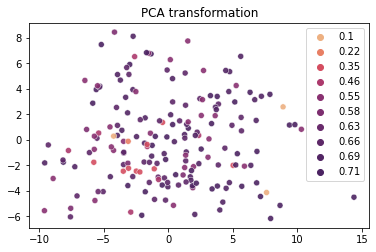

In [ ]:
importlib.reload(nbfuns)

#labels_lowest = np.argmax(ys_lowest, axis=1)
#labels_lowest_test = np.argmax(ys_lowest_test, axis=1),

probs_lowest = clf.predict_proba(xs_lowest)
probs_lowest_test = clf.predict_proba(xs_lowest_test)

#print(labels_lowest)

nbfuns.plot_class_membership_probabilities_with_luminance(
    probs_lowest,
    probs_lowest_test,
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    use_tsne=False,
    luminance_colormap="flare"
)

In [18]:
importlib.reload(nbfuns)

#labels_lowest = np.argmax(ys_lowest, axis=1)
#labels_lowest_test = np.argmax(ys_lowest_test, axis=1),

probs_highest = clf.predict_proba(xs_highest)
probs_highest_test = clf.predict_proba(xs_highest_test)

#print(ys_highest_test)

nbfuns.plot_class_membership_probabilities_with_luminance(
    probs_highest,
    probs_highest_test,
    ys_highest,
    ys_highest_test,
    xs_highest,
    ys_highest,
    use_tsne=True,
    luminance_colormap="flare"
)

Samples with highest membership risk in class 29
[t-SNE] Computing 11 nearest neighbors...
[t-SNE] Indexed 12 samples in 0.000s...
[t-SNE] Computed neighbors for 12 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 12 / 12
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.597298
[t-SNE] KL divergence after 750 iterations: 0.290183
t-SNE done! Time elapsed: 4.7709996700286865 seconds


TypeError: 'ListedColormap' object is not iterable

<Figure size 439.352x271.535 with 0 Axes>

In [ ]:
cls_index = 85

indices = np.where(np.argmax(y_train, axis=1) == cls_index)
xs_new_train = X_train[indices]
ys_new_train = np.argmax(y_train[indices], axis=1)
xs_new_test = X_test[indices]
ys_new_test = np.argmax(y_test[indices], axis=1)

probs_new = clf.predict_proba(xs_new_train)
probs_new_test = clf.predict_proba(xs_new_test)

#print(ys_highest_test)

nbfuns.plot_class_membership_probabilities_with_luminance(
    probs_new,
    probs_new_test,
    ys_new_train,
    ys_new_test,
    xs_new_train,
    ys_new_train,
    use_tsne=False,
    luminance_colormap="flare"
)

Samples with highest membership risk in class 3


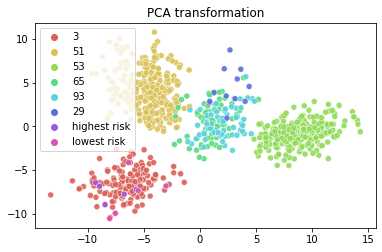

Samples with highest membership risk in class 29


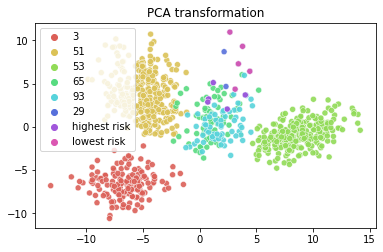

Samples with highest membership risk in class 51


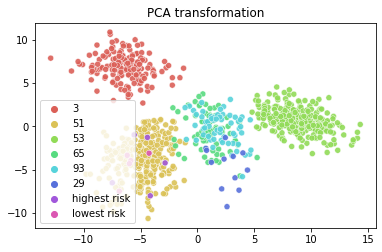

Samples with highest membership risk in class 53


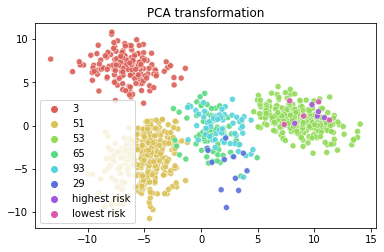

Samples with highest membership risk in class 65


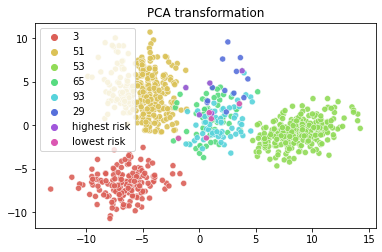

Samples with highest membership risk in class 93


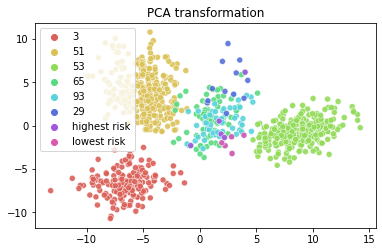

In [56]:
nbfuns.plot_membership_probabilities(
    clf.predict_proba(xs_final),
    clf.predict_proba(xs_final_test),
    ys_final,
    ys_final_test,
    xs_final,
    ys_final,
    num_samples=5,
    use_tsne=False
)

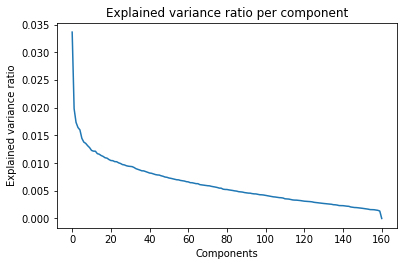

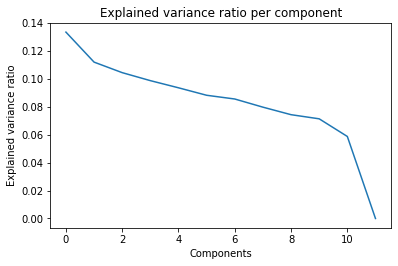

In [43]:
importlib.reload(nbfuns)

pca_lowest, res_lowest = nbfuns.plot_explained_variance_per_component(xs_lowest)
pca_highest, res_highest = nbfuns.plot_explained_variance_per_component(xs_highest)

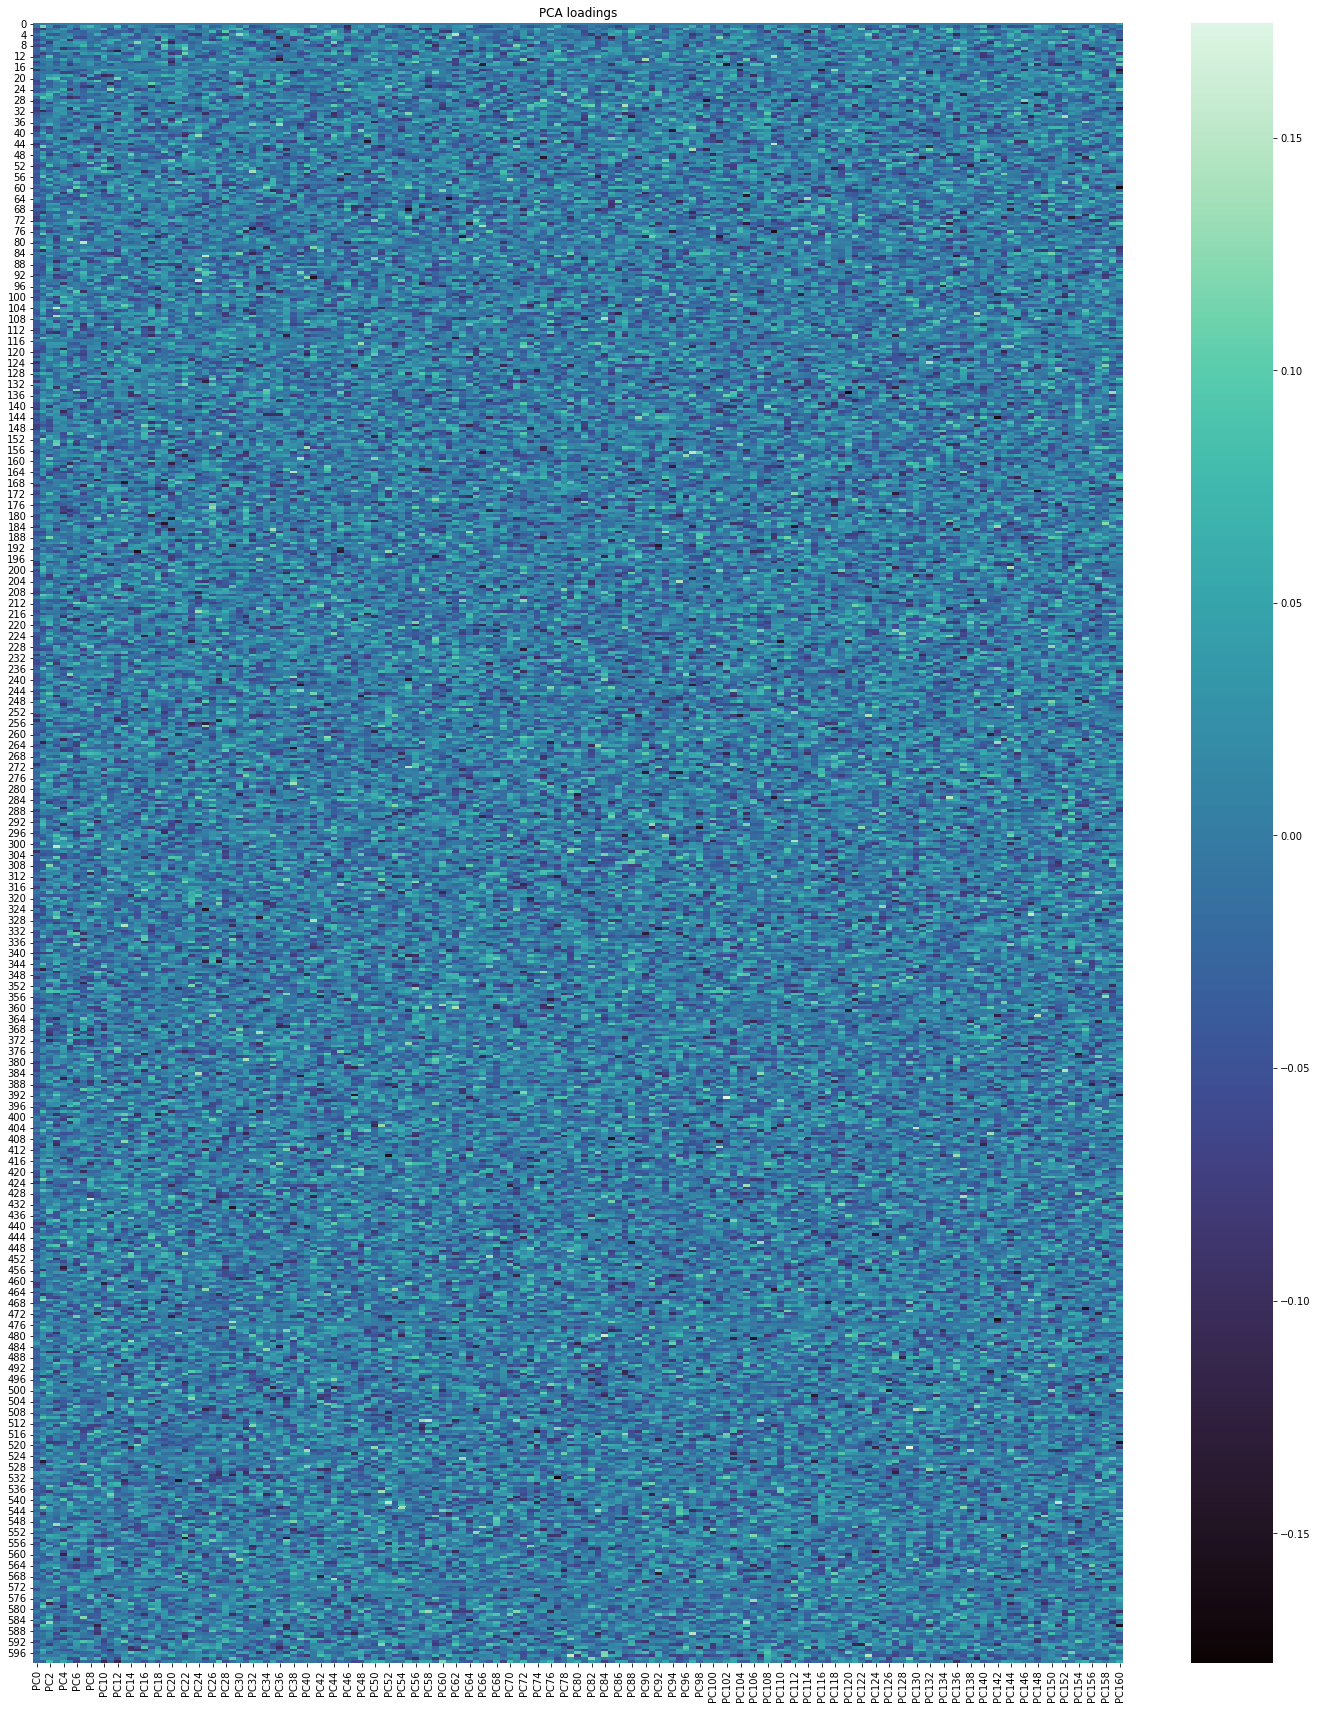

PC0           PC1           PC2           PC3           PC4  \
0    2.299567e-18  1.028959e-17  6.583703e-19  1.147394e-17  4.265010e-17   
1   -1.371692e-02  1.134204e-01  2.029116e-02 -5.630029e-02 -3.315110e-02   
2   -6.312660e-02 -8.287765e-02 -1.137947e-02 -6.115380e-03  4.129704e-02   
3   -4.751052e-02  1.665711e-02  1.145115e-02  3.052444e-02  9.277461e-03   
4   -8.000283e-03  4.705121e-02 -3.850220e-02 -4.513389e-02  5.923849e-03   
..            ...           ...           ...           ...           ...   
595 -2.762551e-03  6.546487e-02  2.323278e-02 -2.714261e-02 -4.326485e-02   
596 -3.799360e-02  4.514031e-02 -3.622301e-02  6.675136e-03 -7.388363e-03   
597 -1.211668e-02 -5.621981e-03 -2.237833e-03 -8.156154e-03  3.023318e-02   
598 -6.454236e-03  3.666584e-02  2.610031e-02  2.618089e-02  1.681784e-02   
599 -1.831101e-02 -3.285979e-02  7.634811e-02  6.423251e-03  4.904113e-02   

              PC5           PC6           PC7           PC8           PC9  \
0   -4.385014e-17 -1.432274e-17  9.606409e-18 -2.900304e-17 -5.089925e-18   
1    2.255128e-02 -7.397056e-03  4.927318e-02  7.686701e-02  2.120160e-02   
2    1.502260e-02 -6.303293e-02  2.779704e-02  1.488586e-02  2.430654e-02   
3   -3.879906e-02 -2.007597e-02 -3.233228e-02  1.203186e-02  2.684091e-04   
4    1.414967e-02 -1.746784e-02 -2.895769e-02 -9.598389e-03  6.184674e-02   
..            ...           ...           ...           ...           ...   
595 -5.157794e-02  6.269137e-03  1.463708e-02  3.845572e-02  3.361094e-02   
596 -5.825029e-03 -3.690317e-02 -2.367647e-02 -2.203584e-02  2.628419e-03   
597 -1.412441e-03  2.226362e-02 -2.433596e-02 -6.720060e-03 -4.496093e-02   
598 -6.080162e-02 -5.588158e-02  8.073721e-02  2.391282e-03  7.281669e-02   
599  9.578404e-03 -7.103525e-02 -1.900831e-02 -2.277337e-02 -1.692189e-02   

     ...         PC151         PC152         PC153         PC154  \
0    ...  4.282020e-17 -8.019794e-17  1.154529e-16 -2.957602e-17   
1    ... -3.756877e-02  2.356168e-03  2.914805e-02  4.088099e-03   
2    ... -3.209156e-02 -8.038539e-02 -6.484890e-02 -2.453061e-02   
3    ...  3.057678e-02  1.076718e-01  2.040469e-02  3.031986e-02   
4    ... -3.214653e-03 -2.584525e-02 -2.684039e-02  8.237952e-03   
..   ...           ...           ...           ...           ...   
595  ...  3.518598e-02 -2.273609e-02 -2.506121e-02 -1.214876e-03   
596  ... -2.000292e-03  2.161797e-02  1.101962e-01 -2.073250e-04   
597  ... -1.513956e-02 -5.989544e-02  1.531637e-02 -5.250433e-02   
598  ...  3.740136e-02  1.119256e-01  1.350367e-02 -3.881637e-03   
599  ...  1.814630e-02 -2.445848e-02 -9.701060e-03  4.913926e-02   

            PC155         PC156         PC157         PC158         PC159  \
0   -4.173746e-17 -7.167917e-17  1.523367e-17  2.346497e-17 -1.603296e-18   
1   -5.749694e-02  6.019179e-02  1.115305e-02 -2.516371e-02 -3.169574e-03   
2    2.878110e-02 -2.692729e-02  2.630814e-02  5.699796e-03 -4.750040e-02   
3    2.211649e-02 -3.573966e-02  7.536724e-02 -6.774461e-02 -9.126096e-03   
4    4.574622e-02 -2.011055e-02  4.715431e-02  4.169537e-02  2.437999e-03   
..            ...           ...           ...           ...           ...   
595  1.691761e-02  4.921674e-02 -1.117640e-02  4.214847e-02 -2.484067e-02   
596  1.065414e-03 -2.003175e-02 -1.056782e-02  1.722755e-02 -5.631370e-02   
597 -1.749924e-02 -2.357078e-02 -5.436146e-03 -4.371263e-03  7.452768e-02   
598 -7.134744e-02  7.484661e-02 -4.816067e-02 -6.283325e-02  7.474381e-04   
599  6.367670e-02 -1.162937e-02  2.350902e-02 -7.703565e-03  2.049310e-02   

        PC160  
0    0.051217  
1   -0.022399  
2    0.004086  
3   -0.043602  
4   -0.037066  
..        ...  
595  0.015150  
596 -0.018740  
597  0.025490  
598  0.007497  
599  0.062057  

[600 rows x 161 columns]

In [44]:
importlib.reload(nbfuns)

coef = 4
new_figsize = (nbfuns._DEFAULT_FIGSIZE[0] * coef, nbfuns._DEFAULT_FIGSIZE[1] * 2 * coef)
df_lowest = pd.DataFrame(xs_lowest)
nbfuns.plot_pca_loadings_heatmap_from_dataframe(df_lowest, pca_lowest, figsize=new_figsize)

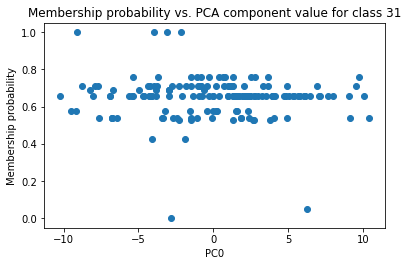

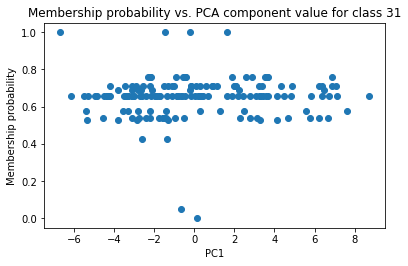

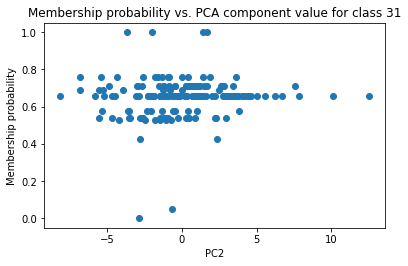

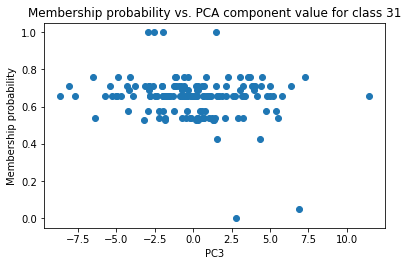

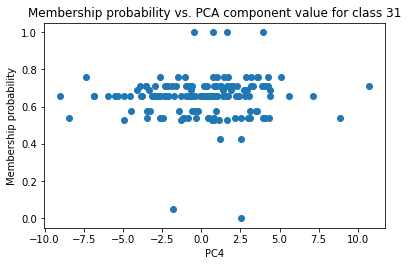

In [45]:
importlib.reload(nbfuns)

nbfuns.plot_pca_component_dependency_on_membership_risk(
    clf.predict_proba(xs_lowest),
    clf.predict_proba(xs_lowest_test),
    ys_lowest,
    ys_lowest_test,
    xs_lowest,
    ys_lowest,
    n_components=5
)

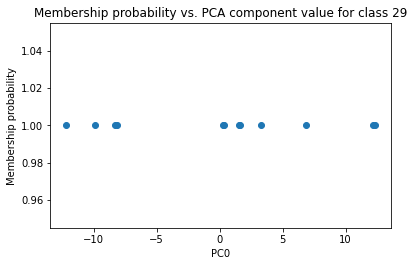

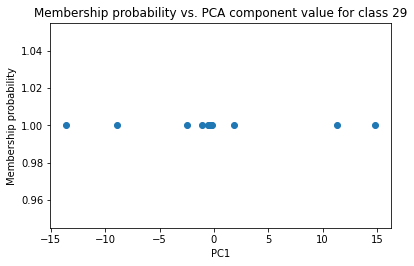

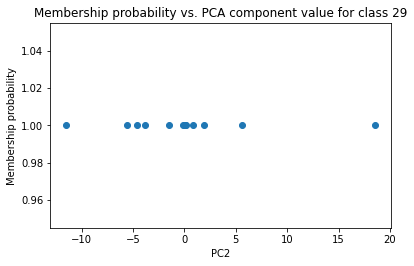

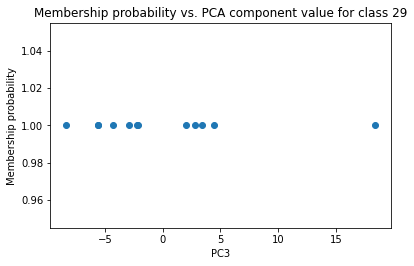

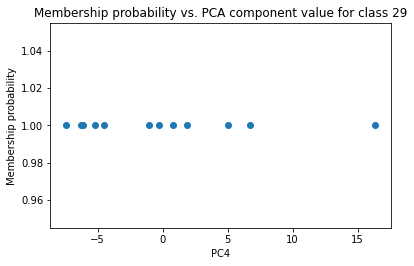

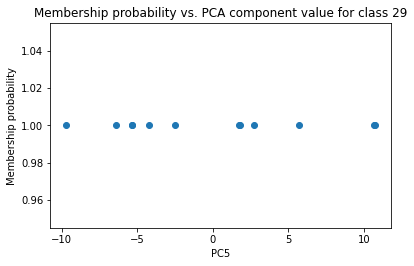

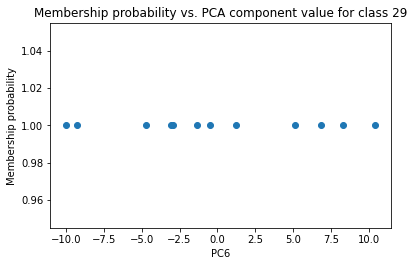

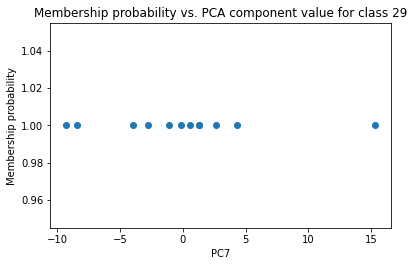

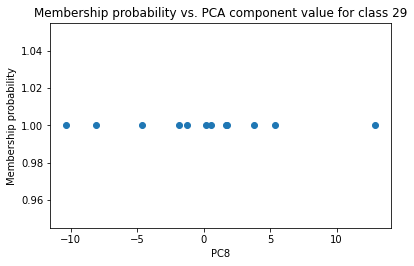

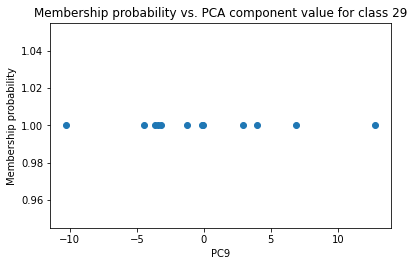

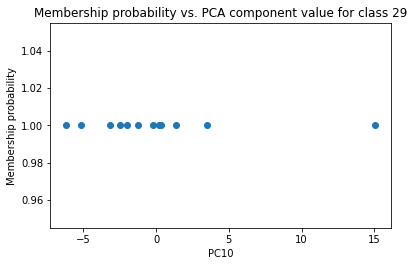

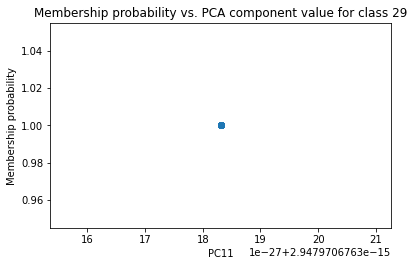

In [46]:
nbfuns.plot_pca_component_dependency_on_membership_risk(
    clf.predict_proba(xs_highest),
    clf.predict_proba(xs_highest_test),
    ys_highest,
    ys_highest_test,
    xs_highest,
    ys_highest,
)

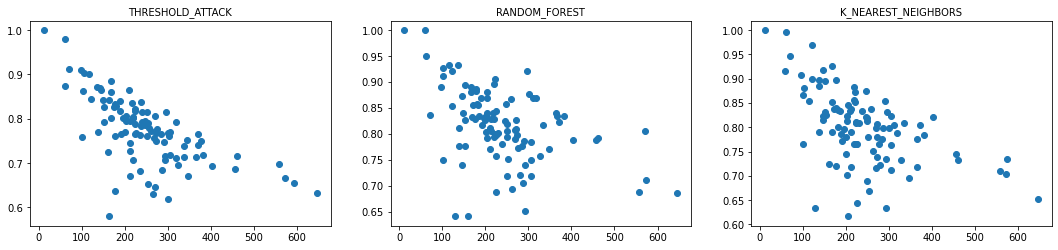

In [21]:
import nbfuns
import matplotlib.pyplot as plt

fsize = (nbfuns._DEFAULT_FIGSIZE[0] * 3, nbfuns._DEFAULT_FIGSIZE[1])
fig, ax = plt.subplots(1, 3, figsize=fsize)
for i, atk_type in enumerate(attack_types):
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    ax[i].scatter(res["train size"], res["AUC"])
    ax[i].set_title(str(atk_type), fontsize="medium")
    #res.plot(
    #   x="train size",
    #    y=["AUC"],
    #    kind="scatter",
    #    layout=(1,2),
    #    xlabel="Class index",
    #    title="AUC: " + str(atk_type),
    #    )
#fig.suptitle('Purchase100 LR: Results Per Slices', fontsize="large")
#fig.subplots_adjust(top=0.88)
plt.savefig("./img/purchase100-atk-types/purchase100-lr.pdf", bbox_inches='tight')

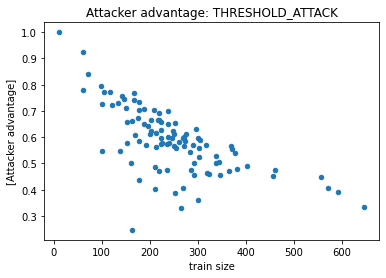

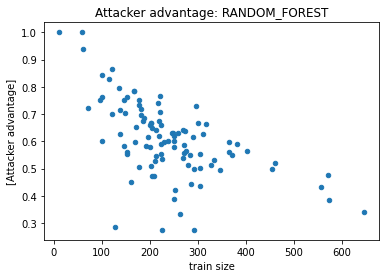

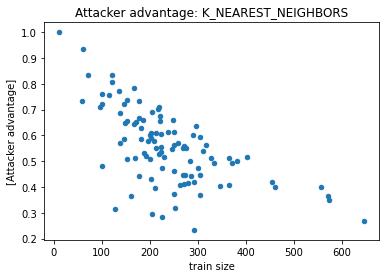

In [48]:
for atk_type in attack_types:
    res = res_df.loc[res_df['attack type'] == str(atk_type)]
    res.plot(
        x="train size",
        y=["Attacker advantage"],
        kind="scatter",
        layout=(1,2),
        xlabel="Class index",
        title="Attacker advantage: " + str(atk_type),
        )

In [50]:

n_classes = 3
sorted_results = res_ta.sort_values(by="AUC")
least_vulnerable = sorted_results[:n_classes]
most_vulnerable = sorted_results[len(sorted_results) - n_classes:]
least_vulnerable

#print(y_train.shape)

xs_lowest, ys_lowest = extract_inputs_using_dataframe_to_empty_ndarray(X_train, y_train, least_vulnerable)
xs_highest, ys_highest = extract_inputs_using_dataframe_to_empty_ndarray(X_train, y_train, most_vulnerable)
xs_final = np.vstack([xs_lowest, xs_highest])
ys_final = np.vstack([ys_lowest, ys_highest])
ys_final = np.argmax(ys_final, axis=1)

xs_lowest_test, ys_lowest_test = extract_inputs_using_dataframe_to_empty_ndarray(X_test, y_test, least_vulnerable)
xs_highest_test, ys_highest_test = extract_inputs_using_dataframe_to_empty_ndarray(X_test, y_test, most_vulnerable)
xs_final_test = np.vstack([xs_lowest_test, xs_highest_test])
ys_final_test = np.vstack([ys_lowest_test, ys_highest_test])
ys_final_test = np.argmax(ys_final_test, axis=1)

#print(ys_final)

Samples with highest membership risk in class 3
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.000s...
[t-SNE] Computed neighbors for 884 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 5.952666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.997475
[t-SNE] KL divergence after 1000 iterations: 1.536583
t-SNE done! Time elapsed: 3.8965706825256348 seconds


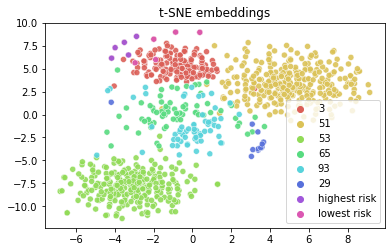

Samples with highest membership risk in class 29
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.000s...
[t-SNE] Computed neighbors for 884 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 5.965453
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.631500
[t-SNE] KL divergence after 1000 iterations: 1.535431
t-SNE done! Time elapsed: 5.009492635726929 seconds


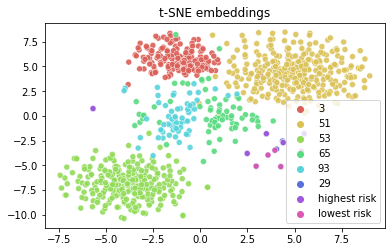

Samples with highest membership risk in class 51
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.005s...
[t-SNE] Computed neighbors for 884 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 5.968767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.298843
[t-SNE] KL divergence after 1000 iterations: 1.535999
t-SNE done! Time elapsed: 3.4755501747131348 seconds


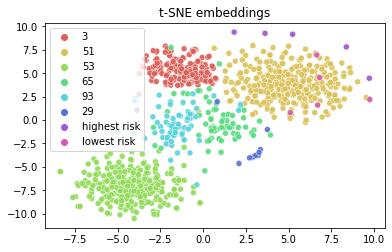

Samples with highest membership risk in class 53
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.000s...
[t-SNE] Computed neighbors for 884 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 5.959343
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.668365
[t-SNE] KL divergence after 1000 iterations: 1.541630
t-SNE done! Time elapsed: 2.891899585723877 seconds


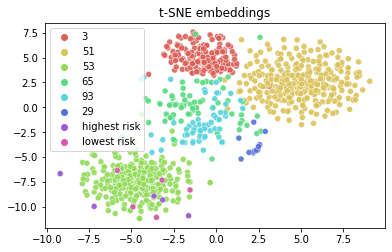

Samples with highest membership risk in class 65
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.000s...
[t-SNE] Computed neighbors for 884 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 5.967827
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.952057
[t-SNE] KL divergence after 1000 iterations: 1.538539
t-SNE done! Time elapsed: 3.1152749061584473 seconds


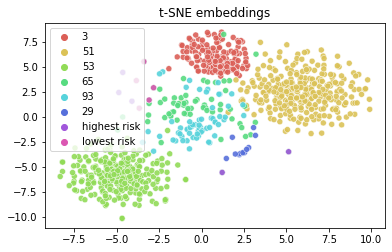

Samples with highest membership risk in class 93
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.001s...
[t-SNE] Computed neighbors for 884 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 5.970275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.785530
[t-SNE] KL divergence after 1000 iterations: 1.535210
t-SNE done! Time elapsed: 4.438126564025879 seconds


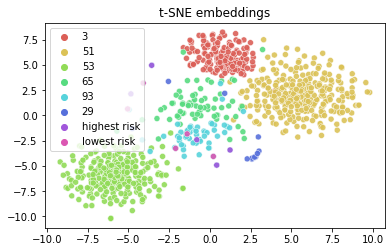

In [55]:
importlib.reload(nbfuns)

nbfuns.plot_membership_probabilities(
    clf.predict_proba(xs_final),
    clf.predict_proba(xs_final_test),
    ys_final,
    ys_final_test,
    xs_final,
    ys_final,
    num_samples=5,
    use_tsne=True
)